# Bounded Clustering - A Clustering Algorithm for Bounded Sized Clusters

## This notebook was created to serve a [blog post]() by the same name.

In [1]:
# written in python 3.7.3
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_blobs

import random
random_seed = 42
random.seed(random_seed)

## Step I - Bounded K-Means Clustering

In [2]:
class ClustersUtils:
    
    @classmethod
    def compute_dist_array(cls, X: np.array) -> np.array:
        dist_array = np.array([[np.linalg.norm(x1 - x2)
                                for x1 in X]
                               for x2 in X])
        return dist_array
    
    @classmethod
    def scatter_plot(cls, X: np.array, clusters_in_idxs: [[int]], centroid_idxs: [int] = None):
        """Only plots first two dimensions"""
        x, y = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                          for one_cluster_in_idxs in clusters_in_idxs
                          for c_idx in one_cluster_in_idxs]))
        c = [color_idx
             for color_idx, one_cluster_in_idxs in enumerate(clusters_in_idxs)
             for _ in one_cluster_in_idxs]
        df = pd.DataFrame({'x': x, 'y': y, 'c': c})

        fig, ax = plt.subplots()
        for color_idx, cluster_in_idxs in enumerate(clusters_in_idxs):
            df_temp = df[df['c'].isin([color_idx])]
            plt.plot(df_temp['x'].tolist(), df_temp['y'].tolist(), 'o', label=color_idx, markersize=5)

        if centroid_idxs is not None:
            x_c, y_c = list(zip(*[[X[c_idx][0], X[c_idx][1]]
                                  for c_idx in centroid_idxs]))
            plt.plot(x_c, y_c, 'o', color='black', markersize=3)

        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()

In [3]:
class BoundedKMeansClustering:
    def __init__(self, n_clusters: int, max_cluster_size: int, n_iter: int = 10, n_init=10, plot_every_iteration=False):
        self.n_clusters = n_clusters
        self.max_cluster_size = max_cluster_size
        self.n_iter = n_iter
        self.n_init = n_init
        self.plot_every_iteration = plot_every_iteration

        self.n_points = None

    def fit(self, X: np.array, weights: np.array, dist_array: np.array = None) -> [float, [[int]]]:
        self.n_points = X.shape[0]
        dist_array = dist_array if dist_array is not None else ClustersUtils.compute_dist_array(X)

        costs, clusters = zip(*[self.fit_one_iteration(X, weights, dist_array) for _ in range(self.n_init)])

        if all(np.isnan(np.array(costs))):
            return np.nan, np.nan
        
        best_idx = np.nanargmin(costs)
        best_cost = costs[best_idx]
        best_clusters = clusters[best_idx]

        self.n_points = None
        return best_cost, best_clusters

    def fit_one_iteration(self, X: np.array, weights: np.array, dist_array: np.array) -> [float, [[int]]]:
        # inspired by https://core.ac.uk/download/pdf/61217069.pdf

        try:
            clusters_in_idxs = self._initialize_clusters(weights, dist_array)
            best_clusters = clusters_in_idxs
            best_cost = self._get_maximal_mean_dist_in_clusters(dist_array, clusters_in_idxs)

            for i in range(self.n_iter):
                clusters_in_idxs, maximal_mean_dist_in_clusters = self._optimize_clusters(X, weights, dist_array,
                                                                                          clusters_in_idxs)
                if clusters_in_idxs == best_clusters:
                    print(f"Reached a local optimum after {i} iterations.")
                    break
                
                if maximal_mean_dist_in_clusters < best_cost:
                    best_cost = maximal_mean_dist_in_clusters
                    best_clusters = clusters_in_idxs
                    
            if self.plot_every_iteration:
                self.scatter_plot(X, best_clusters)

        except ValueError:
            best_cost, best_clusters = np.nan, np.nan

        return best_cost, best_clusters

    def _initialize_clusters(self, weights: np.array, dist_array: np.array) -> [[int]]:
        centroid_idxs = random.sample(range(self.n_points), self.n_clusters)
        clusters_in_idxs = self._assign_points_to_clusters(weights, dist_array, centroid_idxs)
        return clusters_in_idxs

    def _assign_points_to_clusters(self, weights: np.array, dist_array: np.array, centroid_idxs: [int]) -> [[int]]:
        clusters_in_idxs = [[c_idx] for c_idx in centroid_idxs]
        cluster_weights = np.array([weights[c_idx] for c_idx in centroid_idxs])

        sorted_points_idxs_by_weights = [i for i in np.argsort(-weights,  axis=0) if i not in centroid_idxs]
        for p_idx in sorted_points_idxs_by_weights:
            is_assigned = False
            sorted_cluster_idxs_by_dist = np.argsort(dist_array[p_idx][centroid_idxs])
            for c_idx in sorted_cluster_idxs_by_dist:
                if cluster_weights[c_idx] + weights[p_idx] <= self.max_cluster_size:
                    clusters_in_idxs[c_idx].append(p_idx)
                    cluster_weights[c_idx] += weights[p_idx]
                    is_assigned = True
                    break
            if not is_assigned:
                raise ValueError(
                    f"Point {p_idx} could not be assigned. Try with more than {self.n_clusters} clusters. "
                    f"Current_clusters in idxs: {clusters_in_idxs}")

        return clusters_in_idxs

    def _get_maximal_mean_dist_in_clusters(self, dist_array: np.array, clusters_in_idxs: [[int]]):
        mean_dist_in_all_clusters = [self._get_mean_dist_in_cluster(dist_array, one_cluster_in_idxs)
                                     for one_cluster_in_idxs in clusters_in_idxs]
        maximal_mean_dist_in_clusters = max(mean_dist_in_all_clusters)
        return maximal_mean_dist_in_clusters

    def _get_mean_dist_in_cluster(self, dist_array: np.array, cluster_in_idxs: [[int]]) -> float:
        cluster_sub_dist_array = dist_array[cluster_in_idxs, :][:, cluster_in_idxs]
        cluster_sub_dist_array_triu = np.triu(cluster_sub_dist_array)
        cluster_sub_dist_array_triu[cluster_sub_dist_array_triu == 0] = np.nan
        mean_dist_in_cluster = np.nanmean(cluster_sub_dist_array)
        return mean_dist_in_cluster

    def _optimize_clusters(self, X: np.array, weights: np.array, dist_array: np.array, clusters_in_idxs: [[int]]):
        centroid_idxs = self._update_centroids(X, clusters_in_idxs)
        clusters_in_idxs = self._assign_points_to_clusters(weights, dist_array, centroid_idxs)
        maximal_mean_dist_in_clusters = self._get_maximal_mean_dist_in_clusters(dist_array, clusters_in_idxs)        
        return clusters_in_idxs, maximal_mean_dist_in_clusters

    def _update_centroids(self, X: np.array, clusters_in_idxs: [[int]]) -> [int]:
        updated_centroid_idxs = [self._update_centroid_for_one_cluster(X, one_cluster_in_idxs)
                                 for one_cluster_in_idxs in clusters_in_idxs]
        return updated_centroid_idxs

    def _update_centroid_for_one_cluster(self, X: np.array, cluster_in_idxs: [int]) -> int:
        center = np.mean(X[cluster_in_idxs], axis=0)
        closest_point_idx_in_cluster = np.argmin(np.linalg.norm(X[cluster_in_idxs] - center, axis=1))
        closest_point_idx = cluster_in_idxs[closest_point_idx_in_cluster]
        return closest_point_idx

### Small test

Reached a local optimum after 4 iterations.
Best partition to 3 clusters computed in 5.87 seconds.
Total weight = 513.3768828924026
Max_cluster_size = 174.0
Clusters weights: {0: 170.57814308397715, 1: 173.4152763711959, 2: 169.3834634372293}


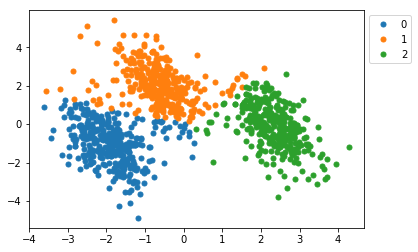

In [4]:
n_points = 1000
n_clusters = 3
n_iter = 10
n_init = 10

centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=n_points, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

weights = np.random.rand(n_points)
max_cluster_size = (sum(weights) // n_clusters) + n_clusters

t = time.time()
cluster_maker = BoundedKMeansClustering(n_clusters, max_cluster_size, n_iter, n_init)
best_cost, best_clusters = cluster_maker.fit(X, weights)
print(f"Best partition to {n_clusters} clusters computed in {round(time.time() - t, 2)} seconds.")
print(f"Total weight = {sum(weights)}")
print(f"Max_cluster_size = {max_cluster_size}")
print(f"Clusters weights: {dict((i, sum(weights[c])) for i, c in enumerate(best_clusters))}")
ClustersUtils.scatter_plot(X, best_clusters)

## Step II - The Elbow Method

In [5]:
class BoundedClustering:
    def __init__(self, max_cluster_size: int, n_iter: int = 10, n_init: int = 10, n_k_to_try: int = 10, 
                 plot_every_iteration=False):
        self.max_cluster_size = max_cluster_size
        self.n_iter = n_iter
        self.n_init = n_init
        self.n_k_to_try = n_k_to_try
        self.plot_every_iteration = plot_every_iteration

    def fit(self, X: np.array, weights: np.array) -> [float, [[int]]]:
        min_n_clusters = int(np.ceil(sum(weights) / self.max_cluster_size))
        max_n_clusters = min([min_n_clusters + self.n_k_to_try, len(weights)])
        all_k = list(range(min_n_clusters, max_n_clusters + 1))

        dist_array = ClustersUtils.compute_dist_array(X)
        costs, clusters = zip(*[self._fit_k(k, X, weights, dist_array) for k in all_k])

        if np.isnan(np.array(costs)).all():
            raise NotEnoughClustersException(f"Could not produce any clustering with range {all_k}.")

        valid_k_indices, all_points = zip(*[[i, np.array([k, cost])]
                                            for i, (k, cost) in enumerate(zip(all_k, costs))
                                            if not np.isnan(cost)])
        if len(valid_k_indices) <= 2:
            i = valid_k_indices[0]
            return all_k[i], clusters[i]

        p_left, p_right = all_points[0], all_points[-1]
        all_distances_from_line = [self._dist_from_line(p_left, p_right, p) for p in all_points]
        best_index_of_k = valid_k_indices[int(np.argmax(all_distances_from_line))]
        best_n_clusters, best_clusters = all_k[best_index_of_k], clusters[best_index_of_k]
        return best_n_clusters, best_clusters
    
    def _fit_k(self, k: int, X: np.array, weights: np.array, dist_array: np.array = None) -> [float, [[int]]]:
        cluster_maker = BoundedKMeansClustering(k, self.max_cluster_size, self.n_iter, self.n_init)
        best_cost, best_clusters = cluster_maker.fit(X, weights, dist_array)
        return best_cost, best_clusters
    
    def _dist_from_line(self, p_left, p_right, p):
        # minus sign because we expect the point to be below the line
        d = -np.cross(p_right - p_left, p - p_left) / np.linalg.norm(p_right - p_left)
        return d
    
#     def _plot_elbow(self, )

### Small test

Reached a local optimum after 8 iterations.
Reached a local optimum after 9 iterations.
Reached a local optimum after 8 iterations.
Reached a local optimum after 7 iterations.
Reached a local optimum after 8 iterations.
Reached a local optimum after 4 iterations.
Reached a local optimum after 2 iterations.
Reached a local optimum after 2 iterations.
Reached a local optimum after 3 iterations.
Reached a local optimum after 6 iterations.
Reached a local optimum after 6 iterations.
Reached a local optimum after 6 iterations.
Reached a local optimum after 9 iterations.
Reached a local optimum after 8 iterations.
Reached a local optimum after 8 iterations.
Reached a local optimum after 5 iterations.
Reached a local optimum after 8 iterations.
Reached a local optimum after 8 iterations.
Reached a local optimum after 7 iterations.
Best partition was found for 6 clusters, computed in 18.36 seconds.
Total weight = 493.6733899072999
Max_cluster_size = 167.0
Clusters weights: {0: 78.2211448448241

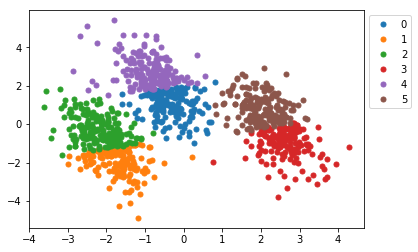

In [6]:
n_points = 1000
n_clusters = 3
n_iter = 10
n_init = 10

centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=n_points, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

weights = np.random.rand(n_points)
max_cluster_size = (sum(weights) // n_clusters) + n_clusters

t = time.time()
cluster_maker = BoundedClustering(max_cluster_size, n_iter, n_init)
best_k, best_clusters = cluster_maker.fit(X, weights)
print(f"Best partition was found for {best_k} clusters, computed in {round(time.time() - t, 2)} seconds.")
print(f"Total weight = {sum(weights)}")
print(f"Max_cluster_size = {max_cluster_size}")
print(f"Clusters weights: {dict((i, sum(weights[c])) for i, c in enumerate(best_clusters))}")
ClustersUtils.scatter_plot(X, best_clusters)

In [7]:
best_cost

1.5384990764524664